### Code : PV Smart-Metering 변수 기초분석
- Writer : Donghyeon Kim
- Date : 2022.07.23
- Data : 태양광 사용가구 '김OO'
- Reason : 1,440개의 행(60분 X 24시간)을 가장 많이 지니고 있는 가구임.

#### 0. 라이브러리 실행 및 기초 설정

In [1]:
# 1. 라이브러리 실행
from pathlib import Path
import os
import pandas as pd
import numpy as np 
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 2. 파일의 상위-상위 경로 설정
os_root = Path(os.path.join(os.getcwd(), '3. variable_basic_analysis.ipynb'))
root = os_root.parent.parent

#### <Data 1 : Weather Data>

#### 1. 데이터 전처리

In [3]:
# weather data 폴더
weather_folder_root = os.path.join(root, 'data_weather')

# csv 파일 이름
csv_name = weather_folder_root + '\\' + 'keei_ldaps.csv'

# 데이터 호출
df_weather = pd.read_csv(csv_name, encoding='cp949')

In [4]:
# 데이터 정제
df_weather['dt'] = pd.to_datetime(df_weather['dt'], format='%Y/%m/%d %H:%M:%S')
df_weather['year'] = df_weather['dt'].dt.year
df_weather['month'] = df_weather['dt'].dt.month
df_weather['day'] = df_weather['dt'].dt.day
df_weather['hour'] = df_weather['dt'].dt.hour

In [5]:
# 태양광 사용 가구 : '김OO'
df_weather_use = df_weather[df_weather.owner == '김OO']

In [6]:
df_weather_use.drop(['owner', 'id_hh', 'id_hs'], axis=1).head(10)

,dt,temperature,uws_10m,vws_10m,ghi,precipitation,relative_humidity_1p5m,specific_humidity_1p5m,year,month,day,hour
637100,2020-09-30 23:00:00+09:00,292.728546,-2.228160,0.237698,0.000000,0.0,68.986772,0.009869,2020,9,30,23
637101,2020-10-01 00:00:00+09:00,292.354248,-1.714996,-0.041465,0.000000,0.0,66.762047,0.009438,2020,10,1,0
637102,2020-10-01 01:00:00+09:00,291.926849,-2.327265,0.925038,0.000000,0.0,68.874672,0.009393,2020,10,1,1
637103,2020-10-01 02:00:00+09:00,291.306183,-3.178022,1.465762,0.000000,0.0,66.956520,0.009054,2020,10,1,2
637104,2020-10-01 03:00:00+09:00,290.812836,-2.551833,2.087108,0.000000,0.0,68.315628,0.009084,2020,10,1,3
637105,2020-10-01 04:00:00+09:00,290.238983,-2.356839,1.550521,0.000000,0.0,71.017899,0.009196,2020,10,1,4
637106,2020-10-01 05:00:00+09:00,289.682648,-2.035041,0.976103,0.000000,0.0,75.187531,0.009352,2020,10,1,5
637107,2020-10-01 06:00:00+09:00,289.475647,-2.591521,0.932820,0.000000,0.0,74.099548,0.009199,2020,10,1,6
637108,2020-10-01 07:00:00+09:00,289.647949,-2.293014,1.221694,8.865723,0.0,72.962921,0.009081,2020,10,1,7
637109,2020-10-01 08:00:00+09:00,291.876373,-2.326365,1.265296,115.951172,0.0,67.094269,0.008840,2020,10,1,8


In [7]:
# 데이터에 해당하는 연도 / 21년도에 해당하는 월 / 22년도에 해당하는 월
# 데이터 기간 : 2021.03 ~ 2022.04
d_year = [2021, 2022]
d_month_21 = range(3, 12+1)
d_month_22 = range(1, 4+1)

In [8]:
# 2021.03 ~ 2022.04 기간에 해당하는 데이터만 필터링
for y in d_year:
    count = 0
    if y == 2021:
        for ma in d_month_21:
            temp = df_weather_use[(df_weather_use.year == y) & (df_weather_use.month == ma)]
            if count == 0:
                result = temp
                count += 1
            else:
                result = pd.concat([result, temp])
    elif y == 2022:
        for mb in d_month_22:
            temp = df_weather_use[(df_weather_use.year == y) & (df_weather_use.month == mb)]
            result = pd.concat([result, temp])

df_weather_use = result

In [9]:
# 온도(temperature) 변환
# 기존 형태 : Kelvin(켈빈 온도) -> 변경하고자 하는 형태 : 섭씨 온도
# 섭씨 온도와 켈빈 온도 관계식 : 0(C) + 273.15(K) = 273.15(K)

df_weather_use.temperature = df_weather_use.temperature - 273.15

In [10]:
# 1분 단위 -> 1일 단위 데이터로 변경

print('1일 단위 데이터로 변경 시작')

# 0) 결과 Dictionary 생성
weather_time = {}
weather_time['year'] = [] # 연도
weather_time['month'] = [] # 월
weather_time['day'] = [] # 일
weather_time['temperature'] = [] # 온도
weather_time['uws_10m'] = [] # x축 풍속(10m 고도)
weather_time['vws_10m'] = [] # y축 풍속(10m 고도)
weather_time['ghi'] = [] # 일사량
weather_time['precipitation'] = [] # 강수량
weather_time['relative_humidity_1p5m'] = [] # 상대습도(1.5m 고도)
weather_time['specific_humidity_1p5m'] = [] # 절대습도(1.5m 고도)

# 1) 연도 필터링
u_year = df_weather_use.year.unique()

# 2) 연도 -> 월 -> 일 필터링 진행한 후, 각 변수별 평균값 산출
for y in u_year:
    day_filter1 = df_weather_use[df_weather_use.year == y]
    
    # 월 필터링
    u_month = day_filter1.month.unique()
    
    for m in u_month:
        day_filter2 = day_filter1[day_filter1.month == m]
        
        # 일 필터링
        u_day = day_filter2.day.unique()
        
        for d in u_day:
            day_filter3 = day_filter2[day_filter2.day == d]
            
            tmp = np.mean(day_filter3.temperature)
            uws = np.mean(day_filter3.uws_10m)
            vws = np.mean(day_filter3.vws_10m)
            ghi = np.mean(day_filter3.ghi)
            prec = np.mean(day_filter3.precipitation)
            rel_humid = np.mean(day_filter3.relative_humidity_1p5m)
            spec_humid = np.mean(day_filter3.specific_humidity_1p5m)
            
            # 결과 Dictionary에 값 대입
            weather_time['year'].append(y)
            weather_time['month'].append(m)
            weather_time['day'].append(d)
            weather_time['temperature'].append(tmp)
            weather_time['uws_10m'].append(uws)
            weather_time['vws_10m'].append(vws)
            weather_time['ghi'].append(ghi)
            weather_time['precipitation'].append(prec)
            weather_time['relative_humidity_1p5m'].append(rel_humid)
            weather_time['specific_humidity_1p5m'].append(spec_humid)
    
df_weather_final = pd.DataFrame(weather_time)
print('1일 단위 데이터로 변경 완료')

1일 단위 데이터로 변경 시작
1일 단위 데이터로 변경 완료


In [11]:
df_weather_final.loc[:, 'ym'] = df_weather_final.year.astype(str) + '/' + df_weather_final.month.astype(str)

In [12]:
df_weather_final.head(10)

,year,month,day,temperature,uws_10m,vws_10m,ghi,precipitation,relative_humidity_1p5m,specific_humidity_1p5m,ym
0,2021,3,1,8.919155,-1.736407,-0.162616,11.935176,2.393112,84.125891,0.005725,2021/3
1,2021,3,2,4.992891,0.314676,-2.043070,161.742922,0.002706,69.686652,0.003057,2021/3
2,2021,3,3,5.865526,-0.040978,1.120929,174.350743,0.000000,68.823934,0.003290,2021/3
3,2021,3,4,7.885524,-0.649182,1.242777,112.909273,0.000000,65.751899,0.004110,2021/3
4,2021,3,5,9.139801,1.099768,-0.691771,185.470508,0.000000,77.935111,0.004660,2021/3
5,2021,3,6,8.497615,-0.739030,-0.535698,107.099635,0.000000,73.328921,0.004252,2021/3
6,2021,3,7,8.145973,0.575023,-0.228959,184.328658,0.000000,65.821113,0.003503,2021/3
7,2021,3,8,8.444373,0.748325,-0.460115,195.469306,0.000000,64.222694,0.003498,2021/3
8,2021,3,9,8.268987,1.356441,0.035522,173.155503,0.000000,68.381816,0.003813,2021/3
9,2021,3,10,9.805317,0.527724,-0.261270,199.231744,0.000000,68.913090,0.004243,2021/3


#### 2. 변수 분석 - '일사량'

#### (1) Boxplot

<AxesSubplot:xlabel='ym', ylabel='ghi'>

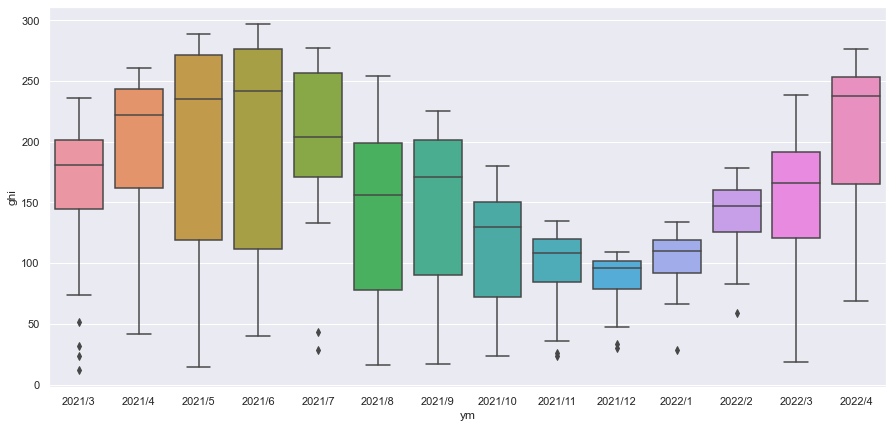

In [13]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.boxplot(y='ghi', x='ym', data=df_weather_final)

#### (2) Basic Statistics

In [14]:
# iloc method : 2021.03 ~ 2022.04
df_weather_final.groupby(['ym']).describe()['ghi'].iloc[3:, :]

,count,mean,std,min,25%,50%,75%,max
ym,,,,,,,,
2021/3,31.0,160.858019,62.983949,11.935176,144.786500,180.460541,201.051813,236.227767
2021/4,30.0,195.345562,67.283049,41.795394,161.457406,222.180574,243.471399,260.735659
2021/5,31.0,194.052253,92.708175,14.557782,119.326683,234.671971,271.112543,288.703326
2021/6,30.0,202.143775,85.859387,39.763939,111.200786,241.605322,276.616128,296.732548
2021/7,31.0,200.802601,62.334175,28.463590,171.177346,203.978061,256.394063,277.282372
2021/8,31.0,141.640861,73.699456,16.054076,77.576549,155.708614,198.852199,253.666007
2021/9,30.0,147.072050,65.950027,16.844483,90.066786,171.098363,201.640496,224.882878
2022/1,31.0,103.575617,23.750622,28.736216,92.033573,109.615780,118.829377,134.055355
2022/2,28.0,139.520220,29.544418,58.804318,125.406777,146.639788,159.900940,178.099767


#### 3. 변수 분석 - '온도'

#### (1) Boxplot

<AxesSubplot:xlabel='ym', ylabel='temperature'>

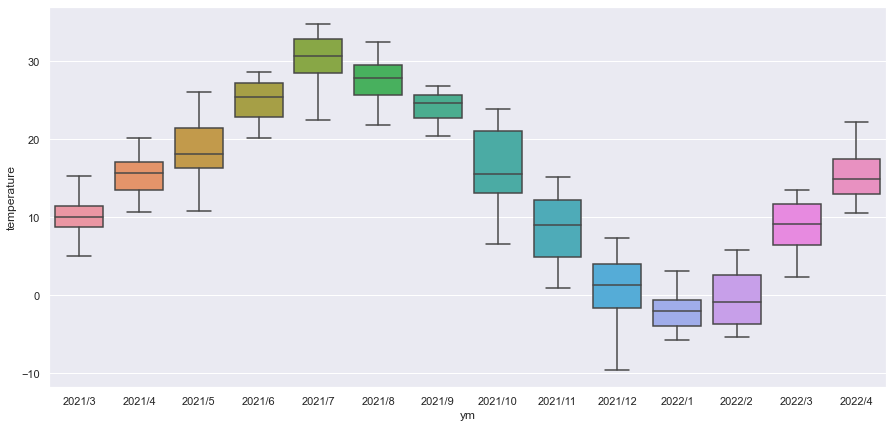

In [15]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.boxplot(y='temperature', x='ym', data=df_weather_final)

#### (2) Basic Statistics

In [16]:
# iloc method : 2021.03 ~ 2022.04
df_weather_final.groupby(['ym']).describe()['temperature'].iloc[3:, :]

,count,mean,std,min,25%,50%,75%,max
ym,,,,,,,,
2021/3,31.0,10.133769,2.381789,4.992891,8.708385,10.016485,11.433576,15.261175
2021/4,30.0,15.466460,2.568734,10.670572,13.483818,15.700511,17.057753,20.183846
2021/5,31.0,18.861826,3.570850,10.801873,16.337334,18.135520,21.460241,26.018458
2021/6,30.0,25.133784,2.554054,20.107743,22.825967,25.456379,27.253023,28.637984
2021/7,31.0,30.496752,3.199052,22.475266,28.495174,30.694840,32.832470,34.742825
2021/8,31.0,27.535790,2.810996,21.852351,25.651594,27.869564,29.502716,32.472133
2021/9,30.0,24.156810,1.959582,20.453994,22.735360,24.655346,25.686759,26.791372
2022/1,31.0,-1.877354,2.311476,-5.702507,-3.912507,-1.974861,-0.570796,3.134847
2022/2,28.0,-0.585899,3.325288,-5.327558,-3.643950,-0.918984,2.585775,5.789713


#### 4. 변수 분석 - 'x축 풍속'

#### (1) Boxplot

<AxesSubplot:xlabel='ym', ylabel='uws_10m'>

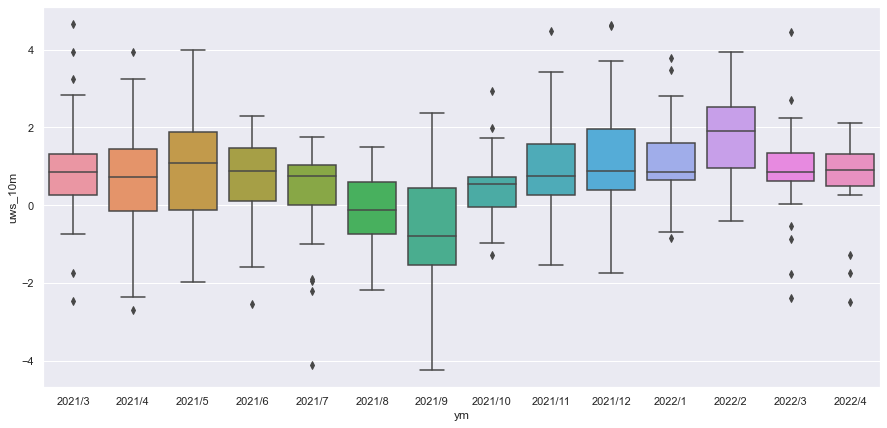

In [17]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.boxplot(y='uws_10m', x='ym', data=df_weather_final)

#### (2) Basic Statistics

In [18]:
# iloc method : 2021.03 ~ 2022.04
df_weather_final.groupby(['ym']).describe()['uws_10m'].iloc[3:, :]

,count,mean,std,min,25%,50%,75%,max
ym,,,,,,,,
2021/3,31.0,0.913920,1.493998,-2.472823,0.252497,0.860340,1.319617,4.654077
2021/4,30.0,0.631529,1.621552,-2.687740,-0.152444,0.718164,1.438693,3.934309
2021/5,31.0,0.868309,1.399918,-1.968245,-0.126479,1.079480,1.868564,3.993279
2021/6,30.0,0.624219,1.121305,-2.550281,0.120206,0.869399,1.459567,2.280455
2021/7,31.0,0.287189,1.311864,-4.117289,0.016592,0.760748,1.035819,1.765012
2021/8,31.0,-0.116943,0.995314,-2.175769,-0.737396,-0.126584,0.604856,1.491948
2021/9,30.0,-0.665540,1.505758,-4.234517,-1.525265,-0.789334,0.454011,2.365470
2022/1,31.0,1.132090,1.052344,-0.853850,0.641326,0.850364,1.590918,3.794980
2022/2,28.0,1.870921,1.134696,-0.418153,0.946472,1.906226,2.534091,3.946182


#### 5. 변수 분석 - 'y축 풍속'

#### (1) Boxplot

<AxesSubplot:xlabel='ym', ylabel='vws_10m'>

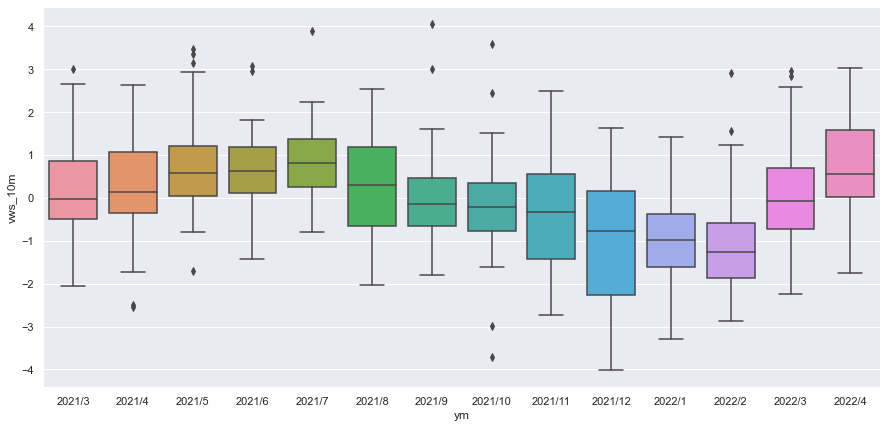

In [19]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.boxplot(y='vws_10m', x='ym', data=df_weather_final)

#### (2) Basic Statistics

In [20]:
# iloc method : 2021.03 ~ 2022.04
df_weather_final.groupby(['ym']).describe()['vws_10m'].iloc[3:, :]

,count,mean,std,min,25%,50%,75%,max
ym,,,,,,,,
2021/3,31.0,0.224292,1.261356,-2.043070,-0.497907,-0.029264,0.865263,3.011769
2021/4,30.0,0.262826,1.328741,-2.548221,-0.355271,0.143068,1.069920,2.624341
2021/5,31.0,0.886090,1.272130,-1.705243,0.039153,0.585101,1.201195,3.472385
2021/6,30.0,0.752111,0.948356,-1.435230,0.125768,0.622407,1.194829,3.071341
2021/7,31.0,0.776511,0.995413,-0.799028,0.263428,0.816904,1.379203,3.889194
2021/8,31.0,0.337827,1.164895,-2.020647,-0.663351,0.293437,1.180691,2.537073
2021/9,30.0,0.066283,1.267706,-1.807123,-0.654942,-0.135370,0.461660,4.052212
2022/1,31.0,-0.880259,1.098547,-3.286058,-1.618409,-0.981481,-0.385302,1.414012
2022/2,28.0,-1.026029,1.323755,-2.865841,-1.869619,-1.251067,-0.577295,2.905425


#### 6. 변수 분석 - '상대 습도'

#### (1) Boxplot

<AxesSubplot:xlabel='ym', ylabel='relative_humidity_1p5m'>

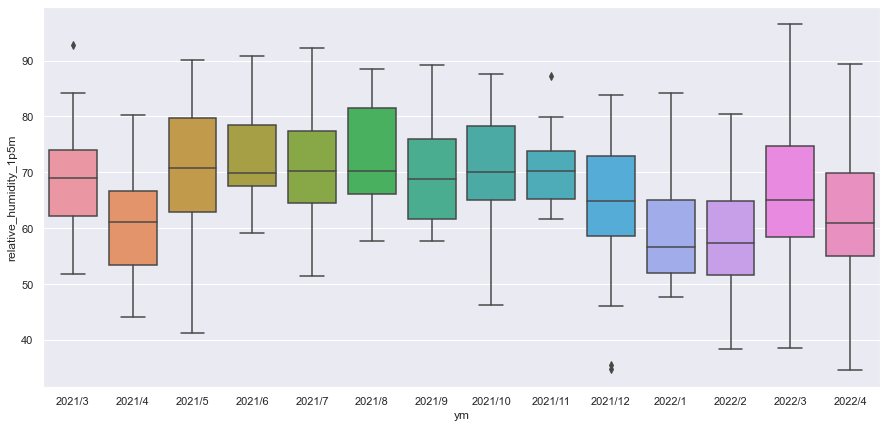

In [21]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.boxplot(y='relative_humidity_1p5m', x='ym', data=df_weather_final)

#### (2) Basic Statistics

In [22]:
# iloc method : 2021.03 ~ 2022.04
df_weather_final.groupby(['ym']).describe()['relative_humidity_1p5m'].iloc[3:, :]

,count,mean,std,min,25%,50%,75%,max
ym,,,,,,,,
2021/3,31.0,68.849258,9.544054,51.819636,62.238967,68.913090,74.031268,92.807657
2021/4,30.0,60.413528,9.112951,44.158033,53.342954,61.071584,66.748660,80.207256
2021/5,31.0,70.228561,11.732446,41.218393,62.953179,70.767296,79.640159,90.073594
2021/6,30.0,72.138396,7.544501,59.089913,67.479840,69.960239,78.493369,90.902795
2021/7,31.0,70.576922,9.667087,51.538592,64.455331,70.203819,77.441062,92.276040
2021/8,31.0,72.877966,9.255292,57.658718,66.094149,70.283741,81.594272,88.566809
2021/9,30.0,70.042124,8.926945,57.682598,61.652016,68.798358,75.949997,89.265995
2022/1,31.0,59.923268,9.533613,47.646761,52.008572,56.664956,65.053208,84.141849
2022/2,28.0,57.969291,11.128652,38.361353,51.553030,57.389595,64.888903,80.517883


#### 7. 변수 분석 - '절대 습도'

#### (1) Boxplot

<AxesSubplot:xlabel='ym', ylabel='specific_humidity_1p5m'>

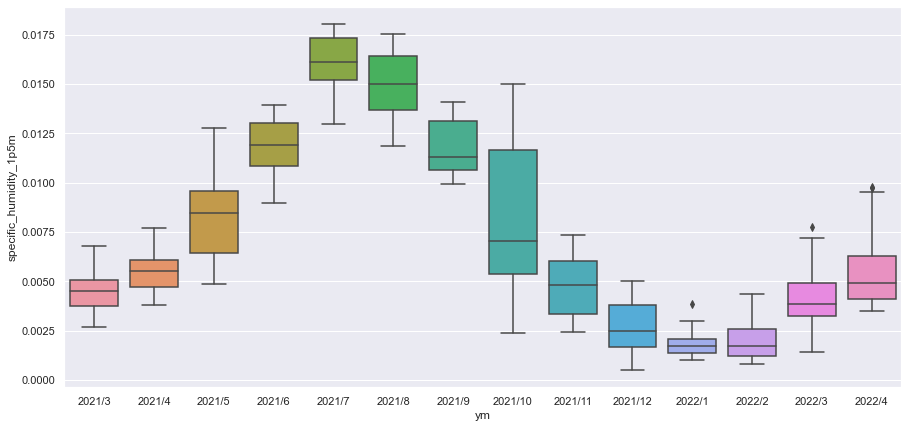

In [23]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.boxplot(y='specific_humidity_1p5m', x='ym', data=df_weather_final)

#### (2) Basic Statistics

In [24]:
# iloc method : 2021.03 ~ 2022.04
df_weather_final.groupby(['ym']).describe()['specific_humidity_1p5m'].iloc[3:, :]

,count,mean,std,min,25%,50%,75%,max
ym,,,,,,,,
2021/3,31.0,0.004480,0.000934,0.002665,0.003761,0.004514,0.005083,0.006788
2021/4,30.0,0.005482,0.000962,0.003779,0.004717,0.005542,0.006068,0.007709
2021/5,31.0,0.008141,0.001836,0.004860,0.006431,0.008484,0.009553,0.012750
2021/6,30.0,0.011794,0.001249,0.008964,0.010829,0.011891,0.013007,0.013935
2021/7,31.0,0.016070,0.001386,0.012951,0.015194,0.016116,0.017341,0.018040
2021/8,31.0,0.014940,0.001655,0.011877,0.013705,0.015015,0.016429,0.017533
2021/9,30.0,0.011745,0.001385,0.009949,0.010625,0.011319,0.013127,0.014087
2022/1,31.0,0.001831,0.000654,0.001020,0.001354,0.001735,0.002090,0.003874
2022/2,28.0,0.001933,0.000924,0.000815,0.001224,0.001698,0.002602,0.004341


#### 8. 변수 분석 - '강수량'

#### (1) Boxplot
- 별 의미가 없는 plot임을 확인할 수 있음.
- 강수량은 dummy variable로 채택하면 좋을 것으로 판단됨.

<AxesSubplot:xlabel='ym', ylabel='precipitation'>

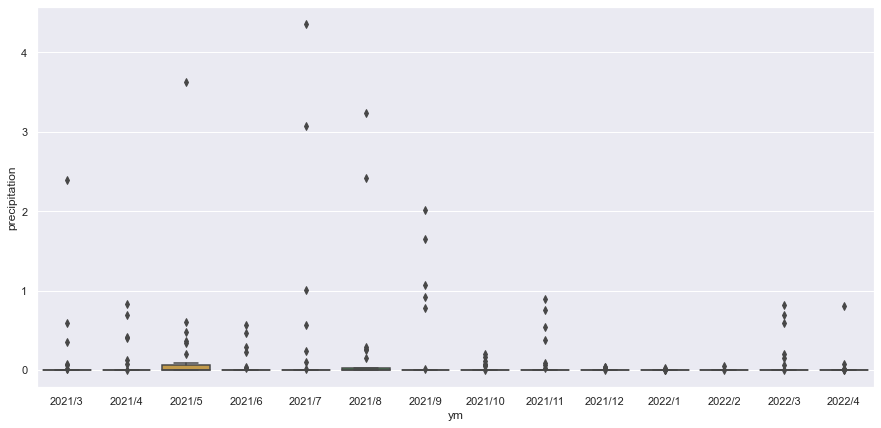

In [25]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.boxplot(y='precipitation', x='ym', data=df_weather_final)

#### (2) Basic Statistics

In [26]:
# iloc method : 2021.03 ~ 2022.04
df_weather_final.groupby(['ym']).describe()['precipitation'].iloc[3:, :]

,count,mean,std,min,25%,50%,75%,max
ym,,,,,,,,
2021/3,31.0,0.112651,0.440586,0.0,0.0,0.0,0.001353,2.393112
2021/4,30.0,0.085441,0.213630,0.0,0.0,0.0,0.000729,0.830358
2021/5,31.0,0.189907,0.656969,0.0,0.0,0.0,0.060656,3.627886
2021/6,30.0,0.053848,0.142911,0.0,0.0,0.0,0.001614,0.567657
2021/7,31.0,0.301330,0.948563,0.0,0.0,0.0,0.000977,4.357869
2021/8,31.0,0.216988,0.710079,0.0,0.0,0.0,0.022146,3.237773
2021/9,30.0,0.214813,0.525113,0.0,0.0,0.0,0.001694,2.012360
2022/1,31.0,0.001491,0.004846,0.0,0.0,0.0,0.000000,0.024817
2022/2,28.0,0.001785,0.009059,0.0,0.0,0.0,0.000000,0.047970


#### <Data 2 : Visibility Data>

#### 1. 데이터 전처리

In [27]:
# ASOS data 폴더
asos_folder_root = os.path.join(root, 'data_ASOS')

# csv 파일 이름
csv_file_name = ['OBS_ASOS_TIM_1.csv', 'OBS_ASOS_TIM_2.csv']

# 데이터 호출
for i in range(len(csv_file_name)):
    csv_name = asos_folder_root + '\\' + csv_file_name[i]
    if i == 0:
        df_asos = pd.read_csv(csv_name, encoding='cp949')
    else:
        temp = pd.read_csv(csv_name, encoding='cp949')
        df_asos = pd.concat([df_asos, temp])

In [28]:
df_asos['일시'] = pd.to_datetime(df_asos['일시'], format='%Y/%m/%d %H:%M:%S')
df_asos['year'] = df_asos['일시'].dt.year
df_asos['month'] = df_asos['일시'].dt.month
df_asos['day'] = df_asos['일시'].dt.day
df_asos['hour'] = df_asos['일시'].dt.hour

In [29]:
df_asos.head(10)

,지점,지점명,일시,시정(10m),year,month,day,hour
0,90,속초,2021-03-01 00:00:00,2000,2021,3,1,0
1,90,속초,2021-03-01 01:00:00,2000,2021,3,1,1
2,90,속초,2021-03-01 02:00:00,2000,2021,3,1,2
3,90,속초,2021-03-01 03:00:00,1951,2021,3,1,3
4,90,속초,2021-03-01 04:00:00,1877,2021,3,1,4
5,90,속초,2021-03-01 05:00:00,1630,2021,3,1,5
6,90,속초,2021-03-01 06:00:00,713,2021,3,1,6
7,90,속초,2021-03-01 07:00:00,794,2021,3,1,7
8,90,속초,2021-03-01 08:00:00,716,2021,3,1,8
9,90,속초,2021-03-01 09:00:00,906,2021,3,1,9


In [30]:
# 지점명 체크
df_asos['지점명'].unique()

array(['속초', '북춘천', '철원', '동두천', '파주', '대관령', '춘천', '백령도', '북강릉', '강릉',
       '동해', '서울', '인천', '원주', '울릉도', '수원', '영월', '충주', '서산', '울진', '청주',
       '대전', '추풍령', '안동', '상주', '포항', '군산', '대구', '전주', '울산', '창원', '광주',
       '부산', '통영', '목포', '여수', '흑산도', '완도', '고창', '순천', '홍성', '제주', '고산',
       '성산', '서귀포', '진주', '강화', '양평', '이천', '인제', '홍천', '태백', '정선군', '제천',
       '보은', '천안', '보령', '부여', '금산', '세종', '부안', '임실', '정읍', '남원', '장수',
       '고창군', '영광군', '김해시', '순창군', '북창원', '양산시', '보성군', '강진군', '장흥', '해남',
       '고흥', '의령군', '함양군', '광양시', '진도군', '봉화', '영주', '문경', '청송군', '영덕',
       '의성', '구미', '영천', '경주시', '거창', '합천', '밀양', '산청', '거제', '남해'],
      dtype=object)

In [31]:
# '김OO' 가구 위치는 '서울'이므로 해당 지역으로 필터링
df_asos_filter = df_asos[df_asos['지점명'] == '서울']

In [32]:
# 1시간 단위 -> 1일 단위 데이터로 변경

print('1일 단위 데이터로 변경 시작')

# 0) 결과 Dictionary 생성
visi_time = {}
visi_time['year'] = [] # 연도
visi_time['month'] = [] # 월
visi_time['day'] = [] # 일
visi_time['visibility'] = [] # 시정

# 1) 연도 필터링
u_year = df_weather_use.year.unique()

# 2) 연도 -> 월 -> 일 필터링 진행한 후, 각 변수별 평균값 산출
for y in u_year:
    day_filter1 = df_asos_filter[df_asos_filter.year == y]
    
    # 월 필터링
    u_month = day_filter1.month.unique()
    
    for m in u_month:
        day_filter2 = day_filter1[day_filter1.month == m]
        
        # 일 필터링
        u_day = day_filter2.day.unique()
        
        for d in u_day:
            day_filter3 = day_filter2[day_filter2.day == d]
            
            vis = np.mean(day_filter3['시정(10m)'])
            
            # 결과 Dictionary에 값 대입
            visi_time['year'].append(y)
            visi_time['month'].append(m)
            visi_time['day'].append(d)
            visi_time['visibility'].append(vis)
    
visi_time_final = pd.DataFrame(visi_time)
print('1일 단위 데이터로 변경 완료')

1일 단위 데이터로 변경 시작
1일 단위 데이터로 변경 완료


In [33]:
visi_time_final.loc[:, 'ym'] = visi_time_final.year.astype(str) + '/' + visi_time_final.month.astype(str)

In [34]:
visi_time_final.head(10)

,year,month,day,visibility,ym
0,2021,3,1,769.291667,2021/3
1,2021,3,2,1935.666667,2021/3
2,2021,3,3,1972.000000,2021/3
3,2021,3,4,1946.875000,2021/3
4,2021,3,5,1768.750000,2021/3
5,2021,3,6,1646.291667,2021/3
6,2021,3,7,1987.916667,2021/3
7,2021,3,8,1886.250000,2021/3
8,2021,3,9,1902.083333,2021/3
9,2021,3,10,820.500000,2021/3


#### 2. 변수 분석 - '시정'

#### (1) Boxplot

<AxesSubplot:xlabel='ym', ylabel='visibility'>

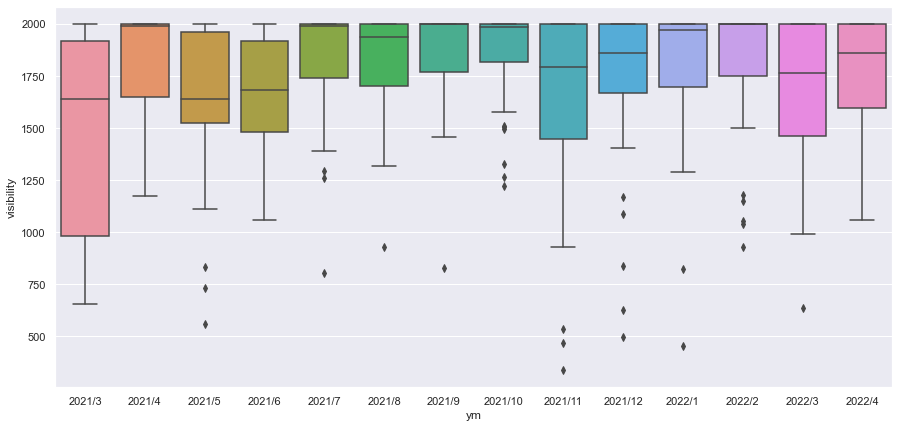

In [35]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.boxplot(y='visibility', x='ym', data=visi_time_final)

#### (2) Basic Statistics

In [36]:
# iloc method : 2021.03 ~ 2022.04
visi_time_final.groupby(['ym']).describe()['visibility'].iloc[3:, :]

,count,mean,std,min,25%,50%,75%,max
ym,,,,,,,,
2021/3,31.0,1477.162634,484.522340,656.875000,979.083333,1637.625000,1918.875000,2000.0
2021/4,30.0,1815.469444,254.997942,1174.583333,1648.031250,1990.187500,2000.000000,2000.0
2021/5,31.0,1620.830645,400.871323,556.583333,1524.166667,1638.500000,1961.270833,2000.0
2021/6,30.0,1655.452778,280.882246,1056.500000,1482.437500,1684.416667,1917.593750,2000.0
2021/7,31.0,1816.673387,297.988846,803.083333,1742.500000,1991.666667,2000.000000,2000.0
2021/8,31.0,1825.365591,257.110591,926.250000,1702.125000,1938.375000,2000.000000,2000.0
2021/9,30.0,1860.731944,252.326563,826.333333,1768.989583,2000.000000,2000.000000,2000.0
2022/1,31.0,1759.418011,374.220072,451.666667,1696.229167,1970.500000,2000.000000,2000.0
2022/2,28.0,1782.857143,358.914222,926.208333,1749.583333,1998.916667,2000.000000,2000.0
